### Cài đặt thư viện cần thiết

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

### Bước 1: Phát hiện và chuẩn hóa khuôn mặt

Matrix X shape: (8, 2500)


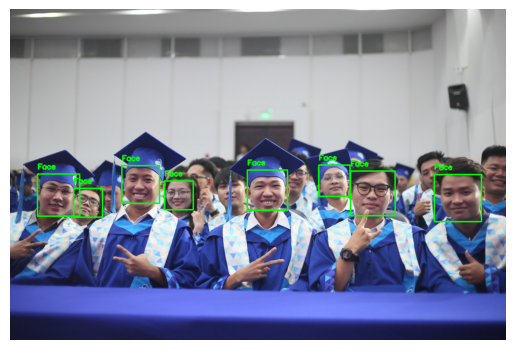

In [2]:
# Đọc ảnh và chuyển sang grayscale
img = cv2.imread('D:\\Python\\test.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Dùng phương pháp Haar cascade để phát hiện khuôn mặt
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Phát hiện khuôn mặt trong ảnh xám
faces = face_cascade.detectMultiScale(
            gray, 
            scaleFactor=1.2, # Tỷ lệ thu phóng trong khoảng 1.1-1.3, ở đây là 1.2 thì ảnh sẽ giảm 20% mỗi lần, giúp phát hiện khuôn mặt nhỏ hơn nhưng chậm
            minNeighbors=6,  # Số lượng vùng lân cận cần thiết để xác định một khuôn mặt, giá trị từ 3-6, giá trị cao hơn sẽ giảm số lượng phát hiện nhưng tăng độ chính xác
            minSize=(20, 20) # Kích thước tối thiểu của khuôn mặt, giá trị này có thể điều chỉnh tùy theo kích thước khuôn mặt trong ảnh
)
# --> Kết quả trả về danh sách các tọa độ (x, y, w, h) của các khuôn mặt phát hiện được

# Các biến lưu khuôn mặt và bounding box
common_size = (50, 50)       # Chuẩn hóa kích thước khuôn mặt về một kích thước chung
face_vectors = []            # Danh sách lưu các vector khuôn mặt đã chuẩn hóa
bounding_boxes = []          # Danh sách lưu vị trí khuôn mặt

# Lặp qua từng khuôn mặt
for (x, y, w, h) in faces:
    face = img[y:y+h, x:x+w]                                    # Cắt khuôn mặt từ ảnh gốc  
    face_resized = cv2.resize(face, common_size)                # Resize về kích thước chuẩn
    face_gray = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)  # Chuyển sang xám
    face_vector = face_gray.flatten().astype(np.float32)        # Flatten (làm phẳng) thành vector 1 chiều
    
    face_vectors.append(face_vector)                            # Lưu trữ vector khuôn mặt đã chuẩn hóa
    bounding_boxes.append((x, y, w, h))                         # Lưu trữ bounding box

# Hiển thị bounding box trên ảnh gốc
for (x, y, w, h) in bounding_boxes:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img, 'Face', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
# cv2.imshow('Detected Faces', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Nếu có khuôn mặt, tạo ma trận dữ liệu X (n_samples, n_features)
if face_vectors:
    X = np.stack(face_vectors)  # Shape: (số ảnh, 2500)
    print(f"Matrix X shape: {X.shape}")
else:
    print("No faces detected.")
    exit()

### Bước 2: Tính toán PCA

In [3]:
# Bước 1: Tính vector trung bình (mean face)
X_mean = np.mean(X, axis=0)  

# Bước 2: Chuẩn hóa dữ liệu (trừ trung bình)
X_centered = X - X_mean 

# Bước 3: Tính ma trận hiệp phương sai (covariance matrix)
cov_matrix = (X_centered.T @ X_centered) / X_centered.shape[0]

# Bước 4: Tính trị riêng và vector riêng
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)  # eigh dùng cho ma trận đối xứng

# Bước 5: Sắp xếp theo trị riêng giảm dần
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Bước 6: Giữ lại K vector riêng đầu tiên
k = 50
U_k = eigenvectors[:, :k] 


### Bước 3: Giảm chiều và tái tạo khuôn mặt

In [4]:
# Biểu diễn khuôn mặt trong không gian mới (giảm chiều)
Z = X_centered @ U_k 

# Tái tạo khuôn mặt đầu tiên từ không gian PCA
reconstructed = Z[0] @ U_k.T + X_mean  
reconstructed_img = reconstructed.reshape(50, 50)


### Bước 4: Hiển thị kết quả

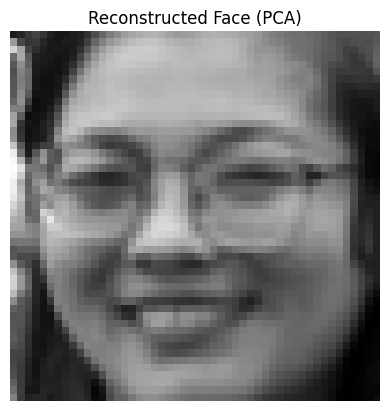

In [12]:
# Hiển thị ảnh khuôn mặt đầu tiên tái tạo từ PCA
plt.imshow(reconstructed_img, cmap='gray')
plt.title('Reconstructed Face (PCA)')
plt.axis('off')
plt.show()